<a href="https://colab.research.google.com/github/HakureiPOI/CIFAR-10-wyx/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Display the shapes of the loaded data
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("CIFAR-10 类别名称:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

CIFAR-10 类别名称:
  0: airplane
  1: automobile
  2: bird
  3: cat
  4: deer
  5: dog
  6: frog
  7: horse
  8: ship
  9: truck


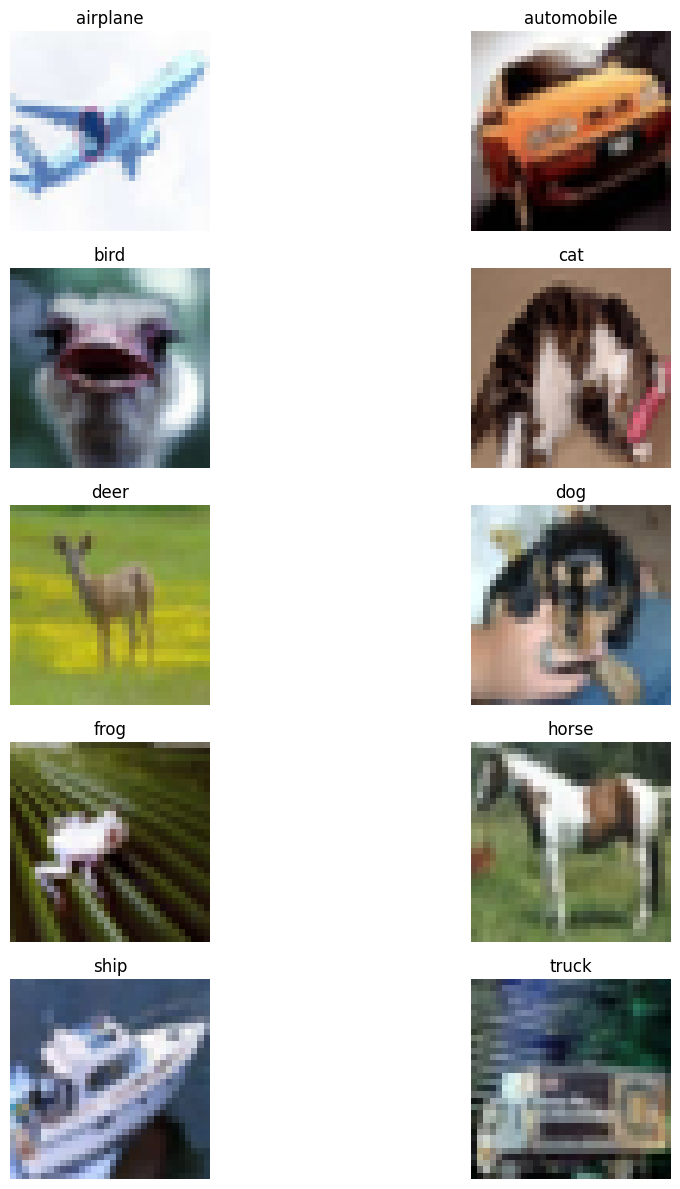

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming class_names, x_train, and y_train are already defined from previous cells

plt.figure(figsize=(12, 12))
for i in range(len(class_names)):
    # Get all images belonging to the current class
    class_indices = np.where(y_train == i)[0]
    # Randomly select one image index from this class
    idx = np.random.choice(class_indices)

    plt.subplot(5, 2, i + 1) # Create a 5x2 grid for 10 classes
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf

def preprocess_image(image, label):
    # Convert image to tf.float32 and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)

    # Random Gaussian blur
    # Apply blur with a probability (e.g., 50% chance)
    if tf.random.uniform(()) > 0.5:
        # Gaussian blur kernel (example, can be made more sophisticated)
        # For simplicity, using a small, fixed kernel size and sigma.
        # For more control, one might use tf.nn.conv2d with a Gaussian kernel.
        # Or, for newer TensorFlow versions, tf.image.gaussian_filter2d
        kernel_size = 3
        sigma = tf.random.uniform(shape=[], minval=0.5, maxval=1.5) # Random sigma

        # Create a 2D Gaussian kernel
        # Adapted from: https://stackoverflow.com/questions/59695679/tensorflow-gaussian-blur-on-image
        def get_gaussian_kernel(kernel_size, sigma, n_channels):
            x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
            x = tf.exp(-(x**2 / (2. * sigma**2)))
            x = x / tf.reduce_sum(x)
            # Corrected: Use tf.einsum for outer product as tf.outer might not be directly available
            kernel = tf.einsum('i,j->ij', x, x)
            kernel = tf.expand_dims(tf.expand_dims(kernel, -1), -1)
            kernel = tf.repeat(kernel, n_channels, axis=2)
            return kernel

        kernel = get_gaussian_kernel(kernel_size, sigma, tf.shape(image)[-1])
        image = tf.nn.depthwise_conv2d(tf.expand_dims(image, 0), kernel, strides=[1, 1, 1, 1], padding='SAME')[0]

    return image, label

print("数据预处理函数已定义：preprocess_image")

数据预处理函数已定义：preprocess_image


In [9]:
BATCH_SIZE = 32

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply preprocessing function to the datasets
# Use num_parallel_calls for faster processing
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("数据预处理和数据集创建完成。")
print(f"训练数据集元素类型: {train_ds.element_spec}")
print(f"测试数据集元素类型: {test_ds.element_spec}")

数据预处理和数据集创建完成。
训练数据集元素类型: (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))
测试数据集元素类型: (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))


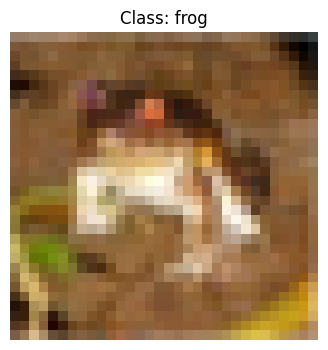

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the training dataset
for images, labels in train_ds.take(1):
    # Select the first image and label from the batch
    sample_image = images[0].numpy()  # Convert TensorFlow tensor to NumPy array
    sample_label_index = labels[0].numpy()[0] # Extract the scalar label index

    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(sample_image)
    plt.title(f"Class: {class_names[sample_label_index]}")
    plt.axis('off')
    plt.show()
    break # Only take one batch and display one image
